# Major assignment (BA885)

In this assignment you will solve a deep learning problem from scratch!

Your company accepts payments over the phone for its services and is now in the process of automating this task. As the sole data scientist on your team, your task is to build and train a voice recognition algorithm to record the customer's credit card number. You will do this in two stages:



1.   Stage 1 (Due April 15): Gather/crowdsource your own data and build a prototype algorithm that recognizes digits.

*   Collect audio samples with the help of your team (classmates). The recordings should have the following specifications: Duration: 1s, sample rate= 16 kHz, file name and format(See example below): {label} _ hash(count_name).wav. Try to collect at least a 100 samples (10 samples per digit).

*   Build a simple model that takes the waveform -- a 16000 component vector -- and classifies it as a digit in [0,...,9].

You can use the "speech commands" dataset for the time being until your own dataset is complete but the final model should only be trained on the samples collected by the class.

You can use this notebook as a template for this assignment. Please share your thoughts on the following questions in your submission.

* What is the acceptable error rate for the model?

* What is the maximum accuracy you can reach with your limited (~3000) number of samples?

* Can you use data generation and transfer learning to improve the performance of your model?




2.   Stage 2 (Due May 6): TBA


#### What is the acceptable error rate for the model?

The acceptable error rate for this model is an accuracy of approximately 10% as there are 10 different digits the model can predict.

#### What is the maximum accuracy you can reach with your limited (~3000) number of samples?
When I initially tried running my model with just under 300 observations I was able to get an accuracy of approximately 50%.


#### Can you use data generation and transfer learning to improve the performance of your model?

Data generation would allow for more data to train the model on, which could potentially increase accuracy as the model can learn more about the data. Similarly, through the use of the weights from the pretrained layers of a model that can be applied to the current data can also help the mdoel further learn and increase accuracy.

## Sample file names:



Use the following format when annotating the files:

{label} _ hash(count_name).wav

Ex: 4_297d828cd9bbfab3fd6a0ad5442e232b.wav

where label is the digit (0,...,9), count is the sample number and name is your name. Hash stands for a hash function, we will use the md5 hash function from hashlib.


In [ ]:
import hashlib

In [ ]:
hashlib.md5(b'120_Stella_Vardanega').hexdigest()

'8aebcefd0642de628a18473c32eafbfa'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
# import glob
# import pandas as pd

In [ ]:
# basePath = '/content/drive/Shareddrives/HW_dataset/mstellav/'
# folders = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
# file_names = []

# for num in folders:
#   path = basePath + str(num)
#   for filename in glob.glob(os.path.join(path, '*.wav')):
#     file_names.append(filename)

# len(file_names)
# files = pd.DataFrame()
# files['Name'] = file_names

In [ ]:
# files.to_csv('file_names.csv', index=False)

## Speech commands dataset

In [ ]:
!pip install tensorflow_io

     |████████████████████████████████| 23.4 MB 1.4 MB/s 


In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import shutil
import random
from collections import Counter

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from sklearn.utils import shuffle

In [ ]:
_ = tf.keras.utils.get_file('speech_commands.tar.gz',
                            'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz',
                            cache_dir='./',
                            cache_subdir='datasets',
                            extract=True)

2428936192/2428923189 [==============================] - 36s 0us/step


In [ ]:
data = []
categories = []
for folder, labels, samples in os.walk('./datasets/'):
    if folder[11:]:
        categories.append(folder[11:])
    for sample in samples:
        if sample[-3:] == 'wav':
            data.append([folder+'/'+sample, folder[11:]])

In [ ]:
data = np.array(data)

In [ ]:
nums_list = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [ ]:
num_samples = Counter(data[:,1])
for num in nums_list:
    print(num+' {}'.format(num_samples[num]))

zero 4052
one 3890
two 3880
three 3727
four 3728
five 4052
six 3860
seven 3998
eight 3787
nine 3934


In [ ]:
data[0]

array(['./datasets/no/4c6944d6_nohash_1.wav', 'no'], dtype='<U50')

In [ ]:
data = pd.DataFrame(data, columns=['filename', 'label'])
data.head()

,filename,label
0,./datasets/no/4c6944d6_nohash_1.wav,no
1,./datasets/no/da93deb7_nohash_1.wav,no
2,./datasets/no/39ec87ac_nohash_0.wav,no
3,./datasets/no/b49caed3_nohash_3.wav,no
4,./datasets/no/f6617a86_nohash_1.wav,no


In [ ]:
data = data[data['label'].isin(nums_list)]

In [ ]:
data['label'].unique()

array(['six', 'eight', 'zero', 'two', 'five', 'nine', 'seven', 'three',
       'four', 'one'], dtype=object)

In [ ]:
data.replace(['nine', 'four', 'eight', 'five', 'three', 'six', 'seven', 'zero', 'two', 'one'],
             [9, 4, 8, 5, 3, 6, 7, 0, 2, 1], inplace = True)

In [ ]:
data['label'].unique()

array([6, 8, 0, 2, 5, 9, 7, 3, 4, 1])

In [ ]:
data = data.sample(n=10000)

## Some useful functions

In [ ]:
def load_audio(filepath):
    try:
        audio = tfio.audio.AudioIOTensor(filepath)
        audio_rate = int(audio.rate)
        assert audio_rate == 16000
        audio = tf.cast(tf.squeeze(audio.to_tensor(), axis=[-1]), tf.float32) / 32767.0
    except:
        return
    len = audio.shape[0]
    # Padding
    if len == 16000:
        return audio
    elif len < 16000:
        return np.concatenate([audio, 
                               np.zeros(shape=(16000-len, ),
                                        dtype="float32")], 
                              axis=0)
    else:
        return audio[:16000]

def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      signals=waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

# Build your model

### Created Digit Dataset

In [ ]:
digit_data = []
for folder, labels, samples in os.walk('/content/drive/Shareddrives/HW_dataset/'):
  for sample in samples:
    if sample[-3:] == 'wav':
      digit_data.append([folder+'/'+sample, sample[:1]])

In [ ]:
digit_data = pd.DataFrame(digit_data, columns = ['filename','label'])
digit_data.head()

,filename,label
0,/content/drive/Shareddrives/HW_dataset/shermj/...,0
1,/content/drive/Shareddrives/HW_dataset/shermj/...,0
2,/content/drive/Shareddrives/HW_dataset/shermj/...,0
3,/content/drive/Shareddrives/HW_dataset/shermj/...,0
4,/content/drive/Shareddrives/HW_dataset/shermj/...,0


In [ ]:
digit_data['label'] = pd.to_numeric(digit_data['label'])

In [ ]:
digit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  921 non-null    object
 1   label     921 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.5+ KB


### Preparing the Data

In [ ]:
data.shape

(10000, 2)

In [ ]:
data_shuffled = data.sample(frac = 1)
nums = round(data.shape[0]*0.9)

In [ ]:
train_data_path = np.array(data_shuffled['filename'][:nums])
train_labels = np.array(data_shuffled['label'][:nums])
test_data_path = np.array(data_shuffled['filename'][nums:])
test_labels = np.array(data_shuffled['label'][nums:])

In [ ]:
# Remove any audio files that are not 16khz as well as their associated label when importing our collected data

train_data = []
train_ind = []
for path in train_data_path:
  audio = load_audio(path)
  if audio is None:
    train_ind.append(np.where(train_data_path == path)[0][0])
    continue
  else:
    train_data.append(audio)

train_labels = np.delete(train_labels, train_ind)

test_data = []
test_ind = []
for path in test_data_path:
  audio = load_audio(path)
  if audio is None:
    test_ind.append(np.where(test_data_path == path)[0][0])
    continue
  else:
    test_data.append(audio)

test_labels = np.delete(test_labels, test_ind)

In [ ]:
train_data = np.array(train_data)
test_data = np.array(test_data)

In [ ]:
train_data.shape

(9000, 16000)

In [ ]:
train_labels.shape

(9000,)

In [ ]:
test_data.shape

(1000, 16000)

In [ ]:
test_labels.shape

(1000,)

### Visualizing a sample audio file

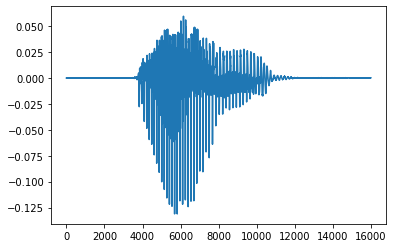

In [ ]:
testing_sample = train_data[-1]


_ = plt.plot(testing_sample)

# Play the audio file.
display.Audio(testing_sample,rate=16000)

In [ ]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

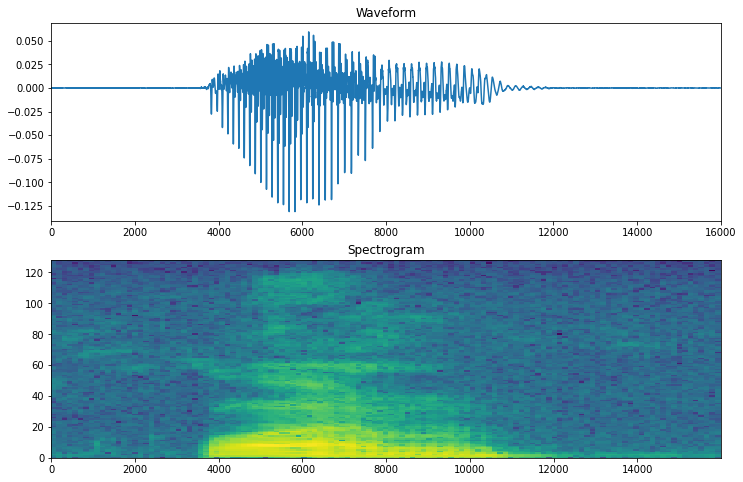

In [ ]:
waveform = testing_sample
spectrogram = get_spectrogram(waveform)
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('Spectrogram')
plt.show()
display.Audio(testing_sample,rate=16000)

### Building a model

In [ ]:
num_labels = len(nums_list)

layer_input = keras.Input(shape=(16000, ))
x = layers.Lambda(lambda x: get_spectrogram(x))(layer_input)
x = layers.Resizing(32, 32)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
layer_output = layers.Dense(num_labels, activation='softmax')(x)

model = keras.Model(inputs = layer_input,
                        outputs = layer_output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16000)]           0         
                                                                 
 lambda (Lambda)             (None, 124, 129, 1)       0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 128)       1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                             

In [ ]:
tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3, restore_best_weights=True)

model.fit(train_data, train_labels, epochs=60, batch_size=256,
          validation_split=0.2, shuffle=True, callbacks = callback)

Epoch 1/60
29/29 [==============================] - 19s 207ms/step - loss: 1.7746 - accuracy: 0.4079 - val_loss: 1.3210 - val_accuracy: 0.5772
Epoch 2/60
29/29 [==============================] - 5s 156ms/step - loss: 1.2371 - accuracy: 0.5903 - val_loss: 0.9823 - val_accuracy: 0.7200
Epoch 3/60
29/29 [==============================] - 5s 160ms/step - loss: 0.9013 - accuracy: 0.7110 - val_loss: 0.7374 - val_accuracy: 0.7883
Epoch 4/60
29/29 [==============================] - 4s 148ms/step - loss: 0.6904 - accuracy: 0.7831 - val_loss: 0.6615 - val_accuracy: 0.8156
Epoch 5/60
29/29 [==============================] - 4s 148ms/step - loss: 0.5789 - accuracy: 0.8169 - val_loss: 0.5503 - val_accuracy: 0.8389
Epoch 6/60
29/29 [==============================] - 5s 157ms/step - loss: 0.4849 - accuracy: 0.8474 - val_loss: 0.5003 - val_accuracy: 0.8528
Epoch 7/60
29/29 [==============================] - 4s 148ms/step - loss: 0.3922 - accuracy: 0.8763 - val_loss: 0.4831 - val_accuracy: 0.8517
Epoch

In [ ]:
model.evaluate(test_data, test_labels)

32/32 [==============================] - 1s 15ms/step - loss: 0.5012 - accuracy: 0.8900


[0.501215398311615, 0.8899999856948853]

In [ ]:
model.save('/content/drive/MyDrive/BA885/Homework/mstellav_model.h5')